In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F 
import os

from tqdm.notebook import tqdm

# Get Images

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
!mkdir /content/dataset

In [4]:
!unzip '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip' -d '/content/dataset'

Archive:  /content/drive/MyDrive/Mestrado/datasets/brain_stroke/brain_data.zip
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (20).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (21).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (22).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (23).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (24).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (25).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (26).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (28).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (29).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (30).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/100 (5).jpg  
  inflating: /content/dataset/Brain_Data_Organised/Test/Normal/1

# Auxiliar Functions

In [5]:
def show_image(image,label,get_denormalize = True):
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    plt.figure(figsize=(8, 8))
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image, title = None):
    image = image.permute(1, 2, 0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.ylabel(title)
    plt.imshow(image)

def show_images(images, labels, row=4, cols=4):
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    fig, axes = plt.subplots(row, cols, figsize = (9, 9))
    axes = axes.flatten()
    for image, label, ax in zip(images, labels, axes):
      image = image.permute(1, 2, 0)  
      image = image*std + mean
      image = np.clip(image,0,1)

      ax.imshow(image)
      ax.set_xlabel(CFG.class_name[label])
    plt.tight_layout()
    plt.show()

def accuracy(y_pred,y_true):
    y_pred = F.softmax(y_pred,dim = 1)
    top_p,top_class = y_pred.topk(1,dim = 1)
    equals = top_class == y_true.view(*top_class.shape)
    return torch.mean(equals.type(torch.FloatTensor))


def view_classify(image,ps,label):
    classes = np.array(CFG.class_name)

    ps = ps.cpu().data.numpy().squeeze()
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    img = np.clip(image,0,1)
    
    fig, (ax1, ax2) = plt.subplots(figsize=(8,12), ncols=2)
    ax1.imshow(img)
    ax1.set_title('Ground Truth : {}'.format(CFG.class_name[label]))
    ax1.axis('off')
    ax2.barh(classes, ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(classes)
    ax2.set_yticklabels(classes)
    ax2.set_title('Predicted Class')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

    return None

def view_patches(image):
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])

    image = image.permute(1, 2, 0)
    image = image*std + mean
    image = np.clip(image,0,1)

    fig = plt.figure(figsize=(8, 8))
    fig.add_axes()
    img = np.asarray(image)
    for i in range(0, 196):
        x = i % 14
        y = i // 14
        patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
        ax = fig.add_subplot(14, 14, i+1)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.imshow(patch)

def view_position_embeddings(pos_embed):
    cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
    fig = plt.figure(figsize=(8, 8))
    for i in range(1, pos_embed.shape[1]):
        sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
        sim = sim.reshape((14, 14)).detach().cpu().numpy()
        ax = fig.add_subplot(14, 14, i)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.imshow(sim)

In [6]:
class CFG:
  epochs = 20                             # No. of epochs for training the model
  lr = 0.001                              # Learning rate
  batch_size = 16                         # Batch Size for Dataset

  model_name = 'vit_small_patch16_224'    # Model name (we are going to import model from timm)
  img_size = 224                          # Resize all the images to be 224 by 224

  # going to be used for loading dataset
  train_path = '/content/dataset/Brain_Data_Organised/Train'
  test_path  = '/content/dataset/Brain_Data_Organised/Test'

  class_name = ["NORMAL", "STROKE"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("On which device we are on:{}".format(device))

On which device we are on:cuda


# Create Datasets

In [7]:
from torchvision import transforms as T, datasets

train_transform = T.Compose([
    T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
    T.RandomRotation(degrees=(-2,+2)), #Randomly Rotate Images by +/- 20 degrees, Image argumentation for each epoch
    T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels
])

validate_transform = T.Compose([
    T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
    #T.RandomRotation(degrees=(-2,+2)), #NO need for validation
    T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels
])

test_transform = T.Compose([
    T.Resize(size=(CFG.img_size,CFG.img_size)), # Resizing the image to be 224 by 224
    #T.RandomRotation(degrees=(-20,+20)), #NO need for validation
    T.ToTensor(), #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]) # Normalize by 3 means 3 StD's of the image net, 3 channels
])

In [8]:
full_dataset = datasets.ImageFolder(CFG.train_path, transform = train_transform)
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_set, valid_set = torch.utils.data.random_split(full_dataset, [train_size, valid_size])
test_set = datasets.ImageFolder(CFG.test_path, transform = test_transform)

In [9]:
print("Trainset Size:  {}".format(len(train_set)))
print("Trainset Size:  {}".format(len(valid_set)))
print("Trainset Size:  {}".format(len(test_set)))

Trainset Size:  1800
Trainset Size:  451
Trainset Size:  250


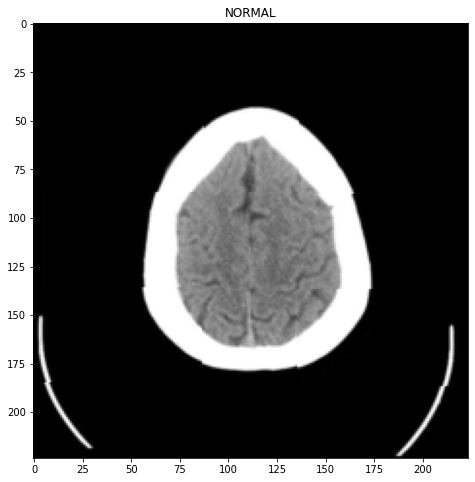

In [10]:
img, label = train_set[200]
show_image(img, CFG.class_name[label])

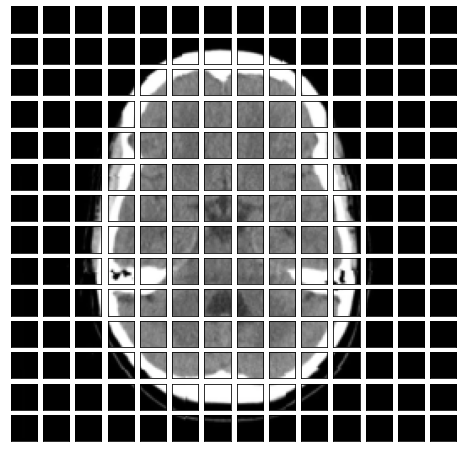

In [ ]:
view_patches(img)

In [ ]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

train_loader = DataLoader(train_set, batch_size = CFG.batch_size, shuffle = True)
print("No. of batches in trainloader: {}".format(len(train_loader))) #Trainset Size:  5216 / batch_size: 16 = 326(No. of batches in trainloader) 
print("No. of Total examples: {}".format(len(train_loader.dataset)))

No. of batches in trainloader: 113
No. of Total examples: 1800


In [ ]:
valid_loader = DataLoader(valid_set, batch_size = CFG.batch_size, shuffle = True)
print("No. of batches in validation loader: {}".format(len(valid_loader))) #validationset Size:  16 / batch_size: 16 = 1(No. of batches in validationloader) 
print("No. of Total examples: {}".format(len(valid_loader.dataset)))

No. of batches in validation loader: 29
No. of Total examples: 451


In [ ]:
test_loader = DataLoader(test_set, batch_size = CFG.batch_size, shuffle = False)
print("No. of batches in testloader: {}".format(len(test_loader))) #testset Size:  624 / batch_size: 16 = 39(No. of batches in testloader) 
print("No. of Total examples: {}".format(len(test_loader.dataset)))

No. of batches in testloader: 16
No. of Total examples: 250


# Show Image Samples

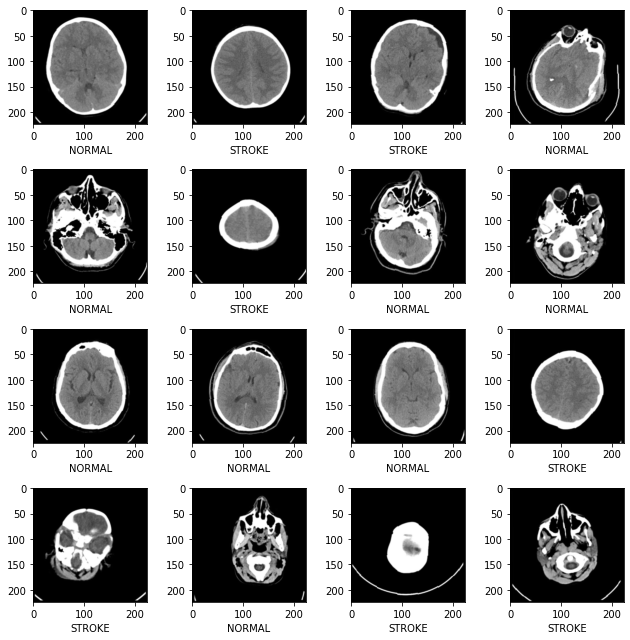

In [ ]:
data_iter = iter(train_loader)
images, labels = next(data_iter)

show_images(images, labels, row=4, cols=4)

# ViT

## Build Model

In [ ]:
!pip install timm # install PyTorch Image Models

     |████████████████████████████████| 376 kB 5.2 MB/s 


In [ ]:
from torch import nn
import torch.nn.functional as F
import timm # PyTorch Image Models

model = timm.create_model(CFG.model_name, pretrained=True, num_classes=2) #load pretrained model

In [ ]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn

In [ ]:
#orginally, it was:
#(classifier): Linear(in_features=1792, out_features=1000, bias=True)

#we are updating it as a 2-class classifier:
model.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

# after updatingnow it becomes:
#(classifier): Sequential(
#    (0): Linear(in_features=1792, out_features=625, bias=True)
#    (1): ReLU()
#    (2): Dropout(p=0.3, inplace=False)
#    (3): Linear(in_features=625, out_features=256, bias=True)
#    (4): ReLU()
#    (5): Linear(in_features=256, out_features=2, bias=True)
#  )

In [ ]:
from torchsummary import summary
model.to(device) # move the model to GPU
summary(model,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 384, 14, 14]         295,296
          Identity-2             [-1, 196, 384]               0
        PatchEmbed-3             [-1, 196, 384]               0
           Dropout-4             [-1, 197, 384]               0
         LayerNorm-5             [-1, 197, 384]             768
            Linear-6            [-1, 197, 1152]         443,520
           Dropout-7          [-1, 6, 197, 197]               0
            Linear-8             [-1, 197, 384]         147,840
           Dropout-9             [-1, 197, 384]               0
        Attention-10             [-1, 197, 384]               0
         Identity-11             [-1, 197, 384]               0
        LayerNorm-12             [-1, 197, 384]             768
           Linear-13            [-1, 197, 1536]         591,360
             GELU-14            [-1, 19

In [ ]:
# position embedding
pos_embed = model.pos_embed
print(pos_embed.shape)

torch.Size([1, 197, 384])


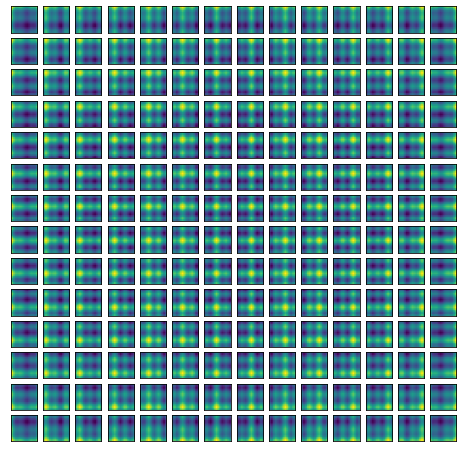

In [ ]:
# Visualize position embedding similarities.
# One cell shows cos similarity between an embedding and all the other embeddings.
view_position_embeddings(pos_embed)

## Train Model

In [ ]:
class CustomTrainer():
    
    def __init__(self, criterion = None, optimizer = None, schedular = None):
        self.criterion = criterion
        self.optimizer = optimizer
        self.schedular = schedular
    
    def train_batch_loop(self, model, trainloader):
        train_loss = 0.0
        train_acc = 0.0
        
        for images,labels in tqdm(trainloader): 
            
            # move the data to CPU
            images = images.to(device)
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            train_loss += loss.item()
            train_acc += accuracy(logits,labels)
            
        return train_loss / len(trainloader), train_acc / len(trainloader) 

    
    def valid_batch_loop(self, model, validloader):
        valid_loss = 0.0
        valid_acc = 0.0
        
        for images,labels in tqdm(validloader):
            
            # move the data to CPU
            images = images.to(device) 
            labels = labels.to(device)
            
            logits = model(images)
            loss = self.criterion(logits,labels)
            
            valid_loss += loss.item()
            valid_acc += accuracy(logits,labels)
            
        return valid_loss / len(validloader), valid_acc / len(validloader)
            
        
    def fit(self, model, trainloader, validloader, epochs):
        valid_min_loss = np.Inf 
        
        for i in range(epochs):
            
            model.train() # this turn on dropout
            avg_train_loss, avg_train_acc = self.train_batch_loop(model,trainloader) ###
            
            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss, avg_valid_acc = self.valid_batch_loop(model,validloader) ###
            
            if avg_valid_loss <= valid_min_loss :
                print("Valid_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),'ViTPytorchModel.pt')
                valid_min_loss = avg_valid_loss

            print("Epoch : {} Train Loss : {:.6f} Train Acc : {:.6f}".format(i+1, avg_train_loss, avg_train_acc))
            print("Epoch : {} Valid Loss : {:.6f} Valid Acc : {:.6f}".format(i+1, avg_valid_loss, avg_valid_acc))

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = CFG.lr)

trainer = CustomTrainer(criterion, optimizer)
trainer.fit(model, train_loader, valid_loader, epochs = CFG.epochs)

  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Valid_loss decreased inf --> 0.6530256692705483
Epoch : 1 Train Loss : 0.712050 Train Acc : 0.582412
Epoch : 1 Valid Loss : 0.653026 Valid Acc : 0.641523


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 2 Train Loss : 0.672200 Train Acc : 0.606195
Epoch : 2 Valid Loss : 0.657662 Valid Acc : 0.650862


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 3 Train Loss : 0.677403 Train Acc : 0.612279
Epoch : 3 Valid Loss : 0.693385 Valid Acc : 0.632184


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 4 Train Loss : 0.671342 Train Acc : 0.631084
Epoch : 4 Valid Loss : 0.657994 Valid Acc : 0.641523


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 5 Train Loss : 0.666249 Train Acc : 0.632190
Epoch : 5 Valid Loss : 0.656975 Valid Acc : 0.641523


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 6 Train Loss : 0.670708 Train Acc : 0.629978
Epoch : 6 Valid Loss : 0.672308 Valid Acc : 0.632184


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Valid_loss decreased 0.6530256692705483 --> 0.6521653286341963
Epoch : 7 Train Loss : 0.669028 Train Acc : 0.630531
Epoch : 7 Valid Loss : 0.652165 Valid Acc : 0.641523


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 8 Train Loss : 0.664651 Train Acc : 0.613385
Epoch : 8 Valid Loss : 0.655923 Valid Acc : 0.641523


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 9 Train Loss : 0.660723 Train Acc : 0.631637
Epoch : 9 Valid Loss : 0.657542 Valid Acc : 0.632184


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 10 Train Loss : 0.667216 Train Acc : 0.627212
Epoch : 10 Valid Loss : 0.659144 Valid Acc : 0.641523


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 11 Train Loss : 0.662643 Train Acc : 0.630531
Epoch : 11 Valid Loss : 0.655743 Valid Acc : 0.641523


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Valid_loss decreased 0.6521653286341963 --> 0.6486774981021881
Epoch : 12 Train Loss : 0.661423 Train Acc : 0.633296
Epoch : 12 Valid Loss : 0.648677 Valid Acc : 0.650862


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 13 Train Loss : 0.660401 Train Acc : 0.631637
Epoch : 13 Valid Loss : 0.659891 Valid Acc : 0.641523


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 14 Train Loss : 0.662197 Train Acc : 0.632190
Epoch : 14 Valid Loss : 0.664156 Valid Acc : 0.622845


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 15 Train Loss : 0.661604 Train Acc : 0.630531
Epoch : 15 Valid Loss : 0.659525 Valid Acc : 0.632184


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 16 Train Loss : 0.661625 Train Acc : 0.628319
Epoch : 16 Valid Loss : 0.654815 Valid Acc : 0.641523


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 17 Train Loss : 0.662929 Train Acc : 0.627212
Epoch : 17 Valid Loss : 0.658890 Valid Acc : 0.632184


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 18 Train Loss : 0.665168 Train Acc : 0.620575
Epoch : 18 Valid Loss : 0.654505 Valid Acc : 0.641523


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Epoch : 19 Train Loss : 0.661616 Train Acc : 0.631084
Epoch : 19 Valid Loss : 0.650989 Valid Acc : 0.650862


  0%|          | 0/113 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

Valid_loss decreased 0.6486774981021881 --> 0.6466924743405704
Epoch : 20 Train Loss : 0.660176 Train Acc : 0.632190
Epoch : 20 Valid Loss : 0.646692 Valid Acc : 0.650862


In [ ]:
!cp '/content/ViTPytorchModel.pt' '/content/drive/MyDrive/Mestrado/datasets/brain_stroke/ViTPytorchModel.pt'

## Evaluate Model

In [ ]:
model.load_state_dict(torch.load('/content/ViTPytorchModel.pt'))
model.eval()

avg_test_loss, avg_test_acc = trainer.valid_batch_loop(model, test_loader)

print("Test Loss : {}".format(avg_test_loss))
print("Test Acc  : {}".format(avg_test_acc))

  0%|          | 0/16 [00:00<?, ?it/s]

Test Loss : 0.7500935327261686
Test Acc  : 0.48828125


## Make Predictions

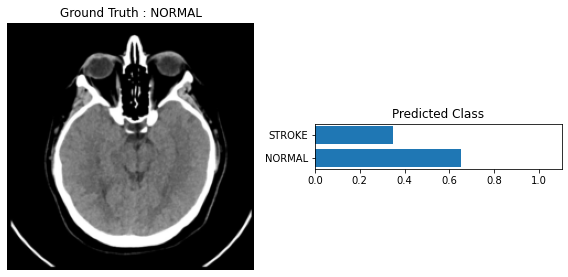

In [ ]:
import torch.nn.functional as F

image, label = test_set[17]
ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps, dim = 1)

view_classify(image, ps, label)

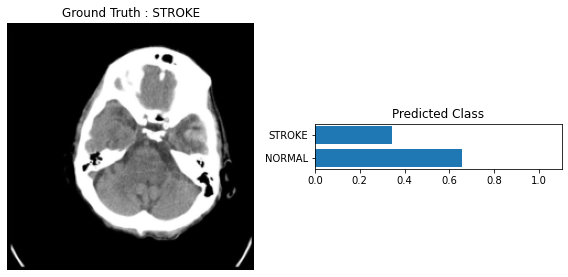

In [ ]:
import torch.nn.functional as F

image, label = test_set[167]
ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps, dim = 1)

view_classify(image, ps, label)

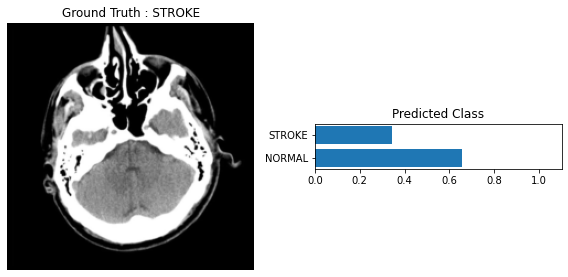

In [ ]:
import torch.nn.functional as F

image, label = test_set[187]
ps = model(image.to(device).unsqueeze(0))
ps = F.softmax(ps, dim = 1)

view_classify(image, ps, label)

In [ ]:
image, label = test_set[89]
o = model(image.to(device).unsqueeze(0))
print(f'Original shape: {o.shape}')
o = model.forward_features(image.to(device).unsqueeze(0))
print(f'Unpooled shape: {o.shape}')

Original shape: torch.Size([1, 2])
Unpooled shape: torch.Size([1, 384])
